# Neural Structured Learning on Time Series
Two novelties are implemented in this notebook:
* Use the GraphNet framework for time-series in order to discover and exploit degradation trends in the same experiment
* Use implicit reparametrization gradients to learn with SGD the parameters of a gamma distribution instead of an empirical error on the output. This is closer to reality and should work better.


## Load data:

In [1]:
from collections import OrderedDict

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd


In [2]:


import os
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

load_from_disk = False;
load_first_stage = True
if load_from_disk:
    def load_bearings_dataset(all_files = all_files):
        fnames = all_files
        exp_ids_tot = [];
        yrem_tot = [];
        sensor_values_tot = []

        for kk,fname in enumerate(fnames):
            p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
            p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
            
            sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
            sens_val = np.dstack([v[1] for v in sensors.values])
            sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
            print(sensor_values.shape)

            yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
            yrem = np.abs(yrem - np.max(yrem))

            exp_id = np.hstack([kk for v in range(yrem.shape[0])])

            sensor_values_tot.append(sensor_values)
            exp_ids_tot.append(exp_id);
            yrem_tot.append(yrem)

            print(kk)

        yrem_tot = np.vstack(yrem_tot).flatten()
        eid = np.hstack(exp_ids_tot).flatten()
        X__ = np.vstack(sensor_values_tot)
        return yrem_tot, eid, X__
    yrem_s_raw, eid, X = load_bearings_dataset()
    
if load_first_stage:
    L = np.load("first_stage_preproc_bearings.npz")
    yrem_s_raw, X, eid = [L[l] for l in L.files]

## Train/Test splitting
* A strong validation set is needed where whole experiments are completely unseen during training.
* Some early interruptions of experiments are suspected to exist in the dataset (from some initial investigations).

In [179]:
normalization_factor_time = 50000#25000; # Manually selected normalization factor
yrem_norm = yrem_s_raw/normalization_factor_time;

yrem_norm[yrem_norm<0.0001] = 0.0001 # For numerical reasons - otherwise NaNs occur.


eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_exp_target  = [1,5,16,  12,13,14,  3]

conds_flag = [*conds_flag_source, *conds_flag_target]
inds_experiments = [*inds_exp_source, *inds_exp_target]
exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
loading_oh = np.zeros([eid_oh.shape[0],3])
for k in np.unique(loading_cond):
    loading_oh[loading_cond == k,k] = 1;


inds_experiments = [*inds_exp_source, *inds_exp_target]

#############################################################
#Remove experiments with too few entries

ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]
min_samples_keep = 910;

exp_and_counts = [(kk,np.sum(eid_oh[:,kk] == 1)) for kk in range(len(inds_experiments))]
inds_exp_source_new = [];
for e,i in exp_and_counts:
    if i>min_samples_keep:
        inds_exp_source_new.append(e)

inds_exp_source = inds_exp_source_new

inds_exp_target = [16,2]
for yy in inds_exp_target:
    inds_exp_source.remove(yy)

counts_dict = OrderedDict(exp_and_counts);
print("training set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_source]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
print("\ntesting set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_target]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    


training set:
01 0 1_7 1502
05 0 1_3 1802
06 0 1_5 2302
07 1 2_3 1202
08 0 1_4 1139
09 1 2_5 2002
13 1 2_1 911
15 0 1_1 2803

testing set:
16 0 1_6 2302
02 2 3_2 1637


In [180]:
inds_exp_target
#inds_exp_source.append(5)
#inds_exp_source.append(7)
#inds_exp_target.remove(5)
#inds_exp_target.remove(7)



[16, 2]

In [181]:
assert(len(set(inds_exp_source).intersection(inds_exp_target)) == 0)

In [182]:
#inds_exp_source = [1,4,6,9,3,11]
#inds_exp_target = [2,5,7,8]
#inds_exp_source = [1,4,6,8]
#inds_exp_target = [5]


In [183]:
[exp_to_cond_dict[i] for i in inds_exp_source],[exp_to_cond_dict[i] for i in inds_exp_target]


([0, 0, 0, 1, 0, 1, 1, 0], [0, 2])

In **GraphNets** I cannot simply randomly sample from different experiments. I need some code to make graph inputs for this dataset.

In [184]:
# inds_exp_target_new = [t for t in inds_experiments if t not in inds_exp_source_new ]
# inds_exp_source = inds_exp_source_new
# inds_exp_target = inds_exp_target_new

In [185]:
# inds_exp_source = [3,2,15,13,4]
# inds_exp_target = [5,8,11,12]

In [186]:



def get_indices_v2(nsamples, ntotal_inds, nmin_idx = 0, nseq_range = None, nmin_idx_diff = None,npoints_per_seq = None,fixed_spacing_indices = False):
        
    for v,vname in zip([nmin_idx, nseq_range, nmin_idx_diff, npoints_per_seq],['nmin_idx', 'nseq_range', 'nmin_idx_diff', 'npoints_per_seq']):
        if v is None:
            raise ValueError("%s cannot be None!"%vname)
        
    nmax_idx = ntotal_inds - nseq_range;
    sample_indices = [];
    for i in range(nsamples):
        
        if fixed_spacing_indices:
            s_ = np.array([i for i in range(1,nseq_range, nmin_idx_diff)]).astype(int)
        else:
            s_ = np.sort(np.random.choice(range(1,nseq_range, nmin_idx_diff), npoints_per_seq, replace = False)).astype(int)
        
        s = np.random.choice(range(nmin_idx,nmax_idx),1) + s_
        sample_indices.append(s)
        
    return np.vstack(sample_indices)
    
i = get_indices_v2(100, 100, nmin_idx = 10,nseq_range = 20, nmin_idx_diff = 2, npoints_per_seq=19, fixed_spacing_indices=True)

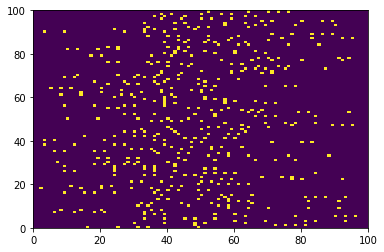

In [187]:

#i = get_indices(100,100,5,spacing_ratio = 0.5)
i = get_indices_v2(100, 100, nmin_idx = 0,nseq_range = 40, nmin_idx_diff = 3,
                   npoints_per_seq=5, fixed_spacing_indices=False)
z = np.zeros([100,100])
#for i_ in i:
#    z[:,i] = 1
for z_, i_ in zip(z[:],i):
    z_[i_] = 1.

pplot.pcolor(z)

In [188]:
from fictitious_example.dataset_utils import *
from fictitious_example.minigraphnets import *

def data_from_experiment(eid, X_ = None, eid_oh_ = None, yrem_norm_ = None):
    ids = (np.argmax(eid_oh_,1) == eid)
    Xexp = X_[ids,:,:];
    yrem_exp_ = yrem_norm_[ids];
    return Xexp, yrem_exp_

def get_graph_data(experiment,  X_ = None, eid_oh_ = None, yrem_norm_ = None, 
                   n_sampled_graphs = 100, nnodes = 3, min_spacing = 20,
                   nseq_range = 100, fixed_spacing_indices = False, node_time_scaling = 5.):
     
    # For computational efficiency the number of nodes and edges in each graph is the same. 
    # For efficiency in creating the dataset, the nodes and edges are also created in parallel.
    exp_dat = data_from_experiment(experiment, X_ = X_, eid_oh_ = eid_oh_, yrem_norm_ = yrem_norm_)
    ntotal_inds = exp_dat[0].shape[0];
    #inds = get_indices(n_sampled_graphs, ntotal_inds, nnodes, fixed_spacing_indices = fixed_spacing_indices)
    #get_indices_v2(100, 100, nmin_idx = 10,nseq_range = 20, nmin_idx_diff = 3,
    #               npoints_per_seq=5, fixed_spacing_indices=False)
    inds = get_indices_v2(n_sampled_graphs, ntotal_inds, nseq_range = nseq_range,
                          npoints_per_seq = nnodes, nmin_idx_diff = min_spacing, 
                          fixed_spacing_indices = fixed_spacing_indices)
    X__, y__ = exp_dat;
    node_attr  = [X__[inds_,...] for inds_ in inds.T];
    node_times = [y__[inds_]*node_time_scaling for inds_ in inds.T]; # to be used for making attributes for the edges.
    nodes= [Node(node_attr_) for node_attr_ in node_attr];
    
    ## Connect all edges with all previous edges:
    edges = []
    for i in range(len(nodes)):
        node_to_idx = i
        
        if node_to_idx == 0:
            next #first node does not have an incoming node.
            
        for node_from_idx in range(0, node_to_idx):
            y_from, y_to = [node_times[ni] for ni in [node_from_idx, node_to_idx]]
            edge_attr = y_to - y_from
            #print("node_from/to: %i %i"%(node_from_idx, node_to_idx))
            edges.append(Edge(edge_attr[:,np.newaxis], node_from = nodes[node_from_idx], node_to = nodes[node_to_idx]));
    g__ =Graph(nodes,edges)
    g__.node_times = node_times
    g__.inds = inds
    return g__,node_times[-1] #Returns a graph and a prediction for the time at the graph's destination node.
    
    

def get_graph_data_multiple_experiments(experiments,X_ = None, eid_oh_ = None, yrem_norm_ = None,
                                        nsamples_per_experiment = None,nnodes = None, min_spacing = None, 
                                        nseq_range = None,fixed_spacing_indices = False):
    all_graph_data = []
    for e in experiments:
        g = get_graph_data(e,  X_ = X_, eid_oh_ = eid_oh_,
                           yrem_norm_ = yrem_norm_,n_sampled_graphs = nsamples_per_experiment,
                           nnodes = nnodes, min_spacing = min_spacing, nseq_range = nseq_range,
                           fixed_spacing_indices = fixed_spacing_indices)
        all_graph_data.append(g)
    return all_graph_data

    

(array([12.,  8., 12., 15., 10., 15.,  3., 10., 11.,  4.]),
 array([0.0062    , 0.04548   , 0.08476   , 0.12404   , 0.16331999,
        0.20259999, 0.24188   , 0.28116   , 0.32044   , 0.35972   ,
        0.399     ], dtype=float32),
 <a list of 10 Patch objects>)

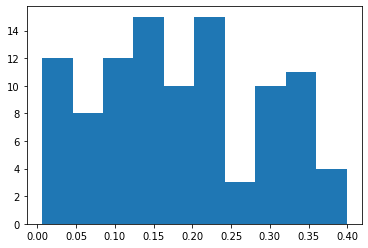

In [189]:
g1= get_graph_data(6, X_ = X, eid_oh_=eid_oh, yrem_norm_= yrem_norm,
               n_sampled_graphs = 100, nnodes = 5,min_spacing = 20,
               nseq_range = 500, fixed_spacing_indices = False, node_time_scaling = 1.)

#pplot.plot(g1[0].node_times[0])
#pplot.plot(g1[0].node_times[-1])
pplot.hist(g1[1])


In [190]:
n = get_graph_data_multiple_experiments(inds_exp_source,X_ = X ,  eid_oh_= eid_oh, yrem_norm_ = yrem_norm, 
                                   nsamples_per_experiment= 100, nnodes = 5, min_spacing = 2,nseq_range=10)

In [191]:
#n = get_graph_data(0, X_ = X, eid_oh_=eid_oh, yrem_norm_= yrem_norm, nnodes = 10,min_idx_spacing = 2, )
n = get_graph_data(0,  X_ = X, eid_oh_ = eid_oh, yrem_norm_ = yrem_norm, nnodes = 19,
                   n_sampled_graphs = 100, min_spacing = 1,
                   nseq_range = 40, fixed_spacing_indices = False, node_time_scaling = 5.)

# Definition of GraphNet functions and the GraphNet:

In [192]:

# activation = None #"relu"
# nheads = 5
# nedge_state = 12

# #pplot.figure(figsize = (10,20))
# for ii,n_degree in enumerate([3,10,15,17]):
#     xin1 = tf.keras.layers.Input(shape = (n_degree,nedge_state)) # 1st dim is number of incoming edges

#     K1 = Dense(nheads, activation = activation, use_bias = False)(xin1)
#     Q1 = Dense(nheads, activation = activation, use_bias=False)(xin1)
#     # nval = 3
#     #attnv = tf.keras.activations.softmax(tf.einsum('ijl, ikm->ijkm',K1,Q1)/(tf.math.sqrt(float(n_degree))), axis = -2)
#     attnv = tf.keras.activations.softmax(
#         tf.einsum('ijl, ikm->ijkm',K1,Q1)/(tf.sqrt(float(nedge_state*nheads))), axis = -2) 
#     #indegree = tf.reduce_sum(tf.exp(xin1[:,:,12] - xin1[:,:,12]),1)
    
#     s = tf.einsum('ijkm,ikl -> ijl',attnv, xin1)/nheads#*tf.sqrt(float(n_degree))# /n_degree
#     #s = tf.reduce_mean(s,-2)
#     #s = keras.layers.LayerNormalization()(s)
#     m = Model(inputs = xin1, outputs=  [s,attnv])
#     t1,t2 = m(np.random.randn(100, n_degree,nedge_state).astype("float32"))
#     pplot.hist(t1.numpy().flatten(), 40,alpha = 0.6, label = n_degree, density = True)
#     #pplot.subplot(5,1,ii+1)
#     #pplot.pcolor(t2.numpy()[0,:,:,0])
    
    
    
    
    
# pplot.legend()

def make_attn_aggregator( nedge_state, n_degree = 1, nheads = 5,activation = None):
    nedges = None
    xin1 = tf.keras.layers.Input(shape = (nedges,nedge_state)) # 1st dim is number of incoming edges

    K1 = Dense(nheads, activation = activation, use_bias = False)(xin1)
    Q1 = Dense(nheads, activation = activation, use_bias=False)(xin1)
    attnv = tf.keras.activations.softmax(
        tf.einsum('...jl, ...km->...jkm',K1,Q1)/(tf.sqrt(float(nedge_state*nheads))), axis = -2) 
    
    s = tf.einsum('...jkm,...kl -> ...jl',attnv, xin1)/nheads#*tf.sqrt(indegree) # I don't know how to get dynamic shape for better properties of the layer...
    s = tf.reduce_mean(s,0)
    #s= tf.keras.layers.LayerNormalization()(s)
    
    return Model(inputs = xin1, outputs=  s)


In [193]:

#f = make_edge_aggregation_function(15)
#f(np.random.randn(100,4,15).astype("float32")).shape

In [194]:
NETWORK_SIZE_GLOBAL = 50
USE_PRENETWORKS = True

def make_gamma_node_observation_mlp():
    """
    Takes as input a node state and returns a gamma probability distribution
    """
    seq = keras.Sequential()
    NParams= 1;
    NSamples = 100;
    #n_gamma_internal = 100;
    
    #seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu", name = "output1"))
    seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x),name = "output"));
    def instantiate_gamma(t):
        return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])
    
    
    seq.add(
        tfp.layers.DistributionLambda(
            make_distribution_fn = lambda t: instantiate_gamma(t),
            convert_to_tensor_fn= lambda s : s.sample(NSamples)))  
    
    return seq
    

def make_edge_function(n_edge_state_input = None,n_edge_state_output = None, n_node_state_input = None):    
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    node_state_sender_in = Input(shape = (n_node_state_input), name = "node_sender");
    node_state_receiver_in = Input(shape = (n_node_state_input), name = "node_receiver");

    ## Building the edge MLP:
    edge_out = keras.layers.concatenate([edge_state_in, node_state_sender_in, node_state_receiver_in])
    
    if USE_PRENETWORKS:
        edge_out = Dense(NETWORK_SIZE_GLOBAL,  use_bias = False,name = "edge_input")(edge_out)
        edge_out = Dropout(rate = 0.2)(edge_out)
        
    edge_out_gate = Dense(n_edge_state_output, activation = "sigmoid", use_bias = False,name = "edge_fcnA")(edge_out)
    edge_outB = Dense(n_edge_state_output, activation = "tanh", use_bias = False,name = "edge_fcnB")(edge_out)
    edge_out =  edge_outB * edge_out_gate #+ (1 - edge_out_gate) * edge_state_in
    
    
    edge_mlp = Model(
        inputs = [edge_state_in, node_state_sender_in, node_state_receiver_in ] ,
        outputs = edge_out)
    
    return edge_mlp


def make_edge_function_gi(n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
    # for graph independent.
    if n_edge_state_output is None:
        n_edge_state_output = n_edge_state_input
            
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    edge_out = edge_state_in
            
    if USE_PRENETWORKS:
        edge_out = Dense(NETWORK_SIZE_GLOBAL,  use_bias = True, name = "edge_gi_input_fcn1")(edge_out)
        edge_out = tf.keras.layers.LeakyReLU()(edge_out)
        edge_out = Dropout(rate = 0.2)(edge_out)
        edge_out = Dense(NETWORK_SIZE_GLOBAL,  use_bias = True, name = "edge_gi_input_fcn2")(edge_out)
        edge_out = tf.keras.layers.LeakyReLU()(edge_out)
    
    edge_out_gate = Dense(n_edge_state_output, use_bias = False, activation = "sigmoid", name = "edge_gi_fcnA")(edge_out)
    edge_outB = Dense(n_edge_state_output, use_bias = False, activation = "tanh", name = "edge_gi_fcnB")(edge_out)
    edge_out = edge_outB * edge_out_gate 
    
    edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)
    
    return edge_mlp


# def per_node_edge_aggregator(node_incoming_edges):
#     """
#     This seems to get the pure edge state.
#     I can pass the node state in the edge 
#     state if I want to have this as well.
#     """
#     edges_in = tf.stack(node_incoming_edges)
#     val  = tf.reduce_mean(edges_in,0) # replace with something better? Attention? Dense Variational?
#     #val = tf.keras.layers.LayerNormalization()(val)
#     return val + np.random.randn(val.shape[0], val.shape[1]).astype("float32")*0.01

def make_edge_aggregation_function(edge_out_shape):
    xin = tf.keras.layers.Input(shape = (None,edge_out_shape))
    xout = tf.reduce_mean(xin,0)
    return Model(inputs = xin, outputs= xout)


def make_node_function(n_edge_state_input = None,n_node_state_input = None):
    agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
    node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

    ## Building the edge MLP:
    node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);
    
    if USE_PRENETWORKS:
        node_out = Dense(NETWORK_SIZE_GLOBAL,  use_bias = True,name = "node_fcn1")(node_out)
        node_out = Dropout(rate = 0.2)(node_out)
        node_out = tf.keras.layers.LeakyReLU()(node_out)
        node_out = Dense(NETWORK_SIZE_GLOBAL,  use_bias = True , name = "node_fcn2")(node_out)
        node_out = tf.keras.layers.LeakyReLU()(node_out)
    #node_out = Dense(n_node_state_input, use_bias = False)(node_out)
    
    node_out_nl = Dense(n_node_state_input, activation = "tanh", use_bias = False,name = "node_fcn_nl")(node_out)
    node_out_gate = Dense(n_node_state_input, activation = "sigmoid", use_bias = False,name = "node_fcn_gate")(node_out)
    node_out = node_out_nl * node_out_gate# + node_prev_state * (1-node_out_gate)
    
    node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)
    
    return node_out_model



def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 18, nfilts2 = 50, ksize = 3, output_size = None):
    
    xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
    xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");
    
    yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA")(xin_node_ts)
    yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnB")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnC")(yout)
    #yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
    yout = tf.keras.layers.LeakyReLU()(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

#     yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA2")(yout)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB2")(yout)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC2")(yout)
#     #yout = Dropout(rate = 0.2)(yout)
#     yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= True)(yout)

    yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA3")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB3")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC3")(yout)
    #yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
    yout = tf.keras.layers.LeakyReLU()(yout)
    #yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA4")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB4")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC4")(yout)
    #yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= True)(yout)
    yout = tf.keras.layers.LeakyReLU()(yout)
    #yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    #yout = keras.layers.GlobalAveragePooling1D()(yout)
    yout = keras.layers.GlobalMaxPooling1D()(yout)
    yout = Dense(output_size, use_bias = True)(yout)
    yout = keras.layers.LayerNormalization()(yout)
    yout = tf.keras.layers.LeakyReLU()(yout)
    
    mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
    # mconv.summary()
    return mconv


class GraphNet:
    """
    Input is a graph and output is a graph.
    """
    def __init__(self, edge_function, node_function, edge_aggregation_function, node_to_prob_function):
        self.edge_function             = edge_function
        self.node_function             = node_function
        self.edge_aggregation_function = edge_aggregation_function        
        self.node_to_prob_function = node_to_prob_function
        # Needed to treat the case of no edges.
        # If there are no edges, the aggregated edge state is zero.
        
        self.edge_input_size = self.edge_function.inputs[0].shape[1] # first input of edge mlp is the edge state size by convention.
        
    def weights(self):
        all_weights = [ *self.edge_function.weights, *self.node_function.weights]
        if self.node_to_prob_function is not None:
            all_weights.extend(self.node_to_prob_function.weights)
        
        if self.edge_aggregation_function is not None and not isinstance(self.edge_aggregation_function, type(tf.reduce_mean)):
            all_weights.extend(self.edge_aggregation_function.weights)
            
        return all_weights
    
    def observe_nodes(self, graph):
        probs = [];
        for n in graph.nodes:
            probs.append(self.node_to_prob_function(n.node_attr_tensor))
            
        return probs
        
    def observe_node(self, node):
        self.node_to_prob_function(node)
        
    def graph_eval(self, graph):
        # Evaluate all edge functions:
        self.eval_edge_functions(graph)
        
        batch_size             = graph.nodes[0].shape[0]; # This will be related to the input graph tuple. 
        
        edge_input_size = self.edge_input_size ; # This relates to the graphnet being evaluated.
        
        # Aggregate edges per node:
        edge_to_node_agg_dummy = np.zeros([batch_size, edge_input_size]);
        
        for n in graph.nodes:
            if len(n.incoming_edges) is not 0:                
                if self.edge_aggregation_function is not None:
                    edge_vals_ = tf.stack([e.edge_tensor for e in n.incoming_edges])
                    edge_to_node_agg = self.edge_aggregation_function(edge_vals_)
                    node_attr_tensor = self.node_function([edge_to_node_agg, n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                else:
                    node_attr_tensor = self.node_function([edge_to_node_agg_dummy,n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                    
            else:
                node_attr_tensor = self.node_function([edge_to_node_agg_dummy, n.node_attr_tensor])
                n.set_tensor(node_attr_tensor)
        
        return graph
    
           
    def eval_edge_functions(self,graph):
        """
        Evaluate all edge functions
        """
        if self.edge_aggregation_function is None:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor])
                edge.set_tensor(edge_tensor)
                
        else:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor, edge.node_from.node_attr_tensor, edge.node_to.node_attr_tensor])
                edge.set_tensor(edge_tensor)


# Building a GraphNet for prediction:

In [195]:
NETWORK_STATES_SIZE = 50
n_node_state_input , n_edge_state_input = [NETWORK_STATES_SIZE,NETWORK_STATES_SIZE]
n_edge_output = n_edge_state_input;
#n_edge_output_gi = n_edge_state_input
n_edge_output_gi = NETWORK_STATES_SIZE
n_node_state_input_gi , n_edge_state_input_gi = [X[0].shape[0],1]

batch_size = 300;


##########################################
# Graph independent processing:
edge_mlp_gi = make_edge_function_gi(n_edge_state_input = n_edge_state_input_gi,
                                    n_edge_state_output= n_edge_output_gi,
                                    n_node_state_input = n_node_state_input_gi)

node_mlp_gi = make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)

node_mlp_gi([np.random.randn(batch_size,n_edge_state_input_gi),np.random.randn(batch_size,n_node_state_input_gi,2)])
graph_indep = GraphNet(edge_function = edge_mlp_gi,
                       node_function = node_mlp_gi,
                       edge_aggregation_function= None, 
                       node_to_prob_function= None)

#########################################
# Graph processing:
edge_mlp = make_edge_function(n_edge_state_input,n_edge_output, n_node_state_input) # THe node state is used for two nodes.
edge_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input), np.random.randn(batch_size,n_node_state_input)]])

node_mlp = make_node_function(n_edge_state_input, n_node_state_input)
node_to_prob_mlp = make_gamma_node_observation_mlp();
node_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input)]])
per_node_edge_aggregator = make_edge_aggregation_function(n_edge_output)
edge_aggregation_function = per_node_edge_aggregator

gn = GraphNet(edge_function = edge_mlp,
              node_function=node_mlp,
              edge_aggregation_function=edge_aggregation_function,
              node_to_prob_function= node_to_prob_mlp)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Training

In [196]:
dat_vals = [v_[ids_filter] for v_ in [X, yrem_norm,eid_oh, loading_oh]]
eid_oh_subs = dat_vals[2];

#dat_vals
## Ballance classes/experiments by resampling:
eid_vals = np.argmax(eid_oh_subs,1);
exp_vals_unique = np.unique(eid_vals)

exp_vals_counts = []
for e in exp_vals_unique:
    exp_vals_counts.append(np.sum(eid == e))

exp_vals_counts = np.array(exp_vals_counts)

resample_factors = [int(np.max(exp_vals_counts)/ee) for ee in exp_vals_counts]
resampling_dict = OrderedDict([(k,v) for k,v in zip(exp_vals_unique,resample_factors)])



In [197]:
def get_multi_batch(nsamples_per_experiment, source_ds = True, nseq_range = None, 
                    nnodes = None, min_spacing = None,fixed_spacing_indices = False):
    # In order to keep the datapoints from each experiment ballanced I'm 
    # sampling the same number of graphs from each experiment
    
    if source_ds:
        args = inds_exp_source
    else:
        args = inds_exp_target
        
    kwargs = {"X_" : X, 
              "yrem_norm_" : yrem_norm,
             "eid_oh_" : eid_oh,
             "nsamples_per_experiment" : nsamples_per_experiment,
             "nnodes" : nnodes,
              "nseq_range" : nseq_range,
              "min_spacing" : min_spacing,
             "fixed_spacing_indices" : fixed_spacing_indices}

    return get_graph_data_multiple_experiments(args, **kwargs)
   

In [198]:
curr_data = get_multi_batch(3, source_ds=True,nnodes=5,
                            min_spacing = 1,
                            nseq_range = 100,
                            fixed_spacing_indices=False);
#eval_graphnets(curr_data[0][0].copy())

In [199]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))

class EarlyStopping:
    def __init__(self, patience, loss_handle):
        self.patience = patience
        self.loss_handle = loss_handle
    
    def on_epoch_end(self, epoch):
        break_ = False
        
        if len(self.loss_handle) > 1:
            if np.all(np.min(self.loss_handle[-self.patience:]) > self.min_val):
                print("*** Early stopping. ***")
                break_ = True
                
            else:
                self.min_val = np.min(self.loss_handle)
        else:
            
            self.min_val = self.loss_handle[-1]
        
        return break_
    
class LRScheduler:
    def __init__(self, opt_object, epoch_decay = 50, decay_rate = 0.95):
        self.opt_object = opt_object
        self.epoch_decay = epoch_decay
        self.decay_rate = decay_rate
        
    def on_epoch_end(self,epoch):
        if epoch >= self.epoch_decay:
            lr = self.opt_object.lr.numpy()
            new_lr = lr * self.decay_rate
            print("setting lr to %2.3f"%new_lr)
            self.opt_object.lr.assign(new_lr)
        
        

In [200]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipnorm = 1)
loss_log = LossLogger()
early_stop = EarlyStopping(20,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 50)

In [201]:

#@tf.function
def eval_graphnets(graph_data_, iterations = 2):
    graph_out = graph_indep.graph_eval(graph_data_)
    for iterations in range(iterations):
        graph_out = gn.graph_eval(graph_out) + graph_out
        
    return node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)

#@tf.function
def eval_graphnets_loss(graph_curr_, ycurr_, iterations):#,iterations):
    graph_out = graph_indep.graph_eval(graph_curr_)
    
    for iterations in range(iterations):
        graph_out = gn.graph_eval(graph_out) + graph_out

    prob_out = node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)
    loss_vals = -prob_out.log_prob(ycurr_)
    return loss_vals


def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp.copy()]
    for iterations in range(iterations):
        graph_out_tmp = gn.graph_eval(graph_out_tmp) + graph_out
        lat_states.append(graph_out_tmp.copy())
    return lat_states

In [202]:
#lr_scheduler.opt_object.lr.assign(lr_scheduler.opt_object.lr.numpy()*0.9)
lr_scheduler.opt_object.lr.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

nnodes: 10, seq_range 200 epoch: 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

loss: 5.914, val_loss 6.878


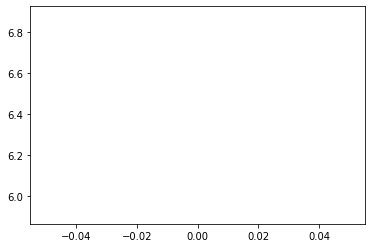

nnodes: 2, seq_range 150 epoch: 1
loss: 5.543, val_loss 6.277
nnodes: 5, seq_range 100 epoch: 2
loss: 5.454, val_loss 5.997
nnodes: 1, seq_range 200 epoch: 3
loss: 6.520, val_loss 7.530
nnodes: 10, seq_range 150 epoch: 4
loss: 5.038, val_loss 5.542
nnodes: 2, seq_range 100 epoch: 5
loss: 5.362, val_loss 6.174
nnodes: 5, seq_range 200 epoch: 6
loss: 4.891, val_loss 5.494
nnodes: 1, seq_range 150 epoch: 7
loss: 5.576, val_loss 6.215
nnodes: 10, seq_range 100 epoch: 8
loss: 5.435, val_loss 6.054
nnodes: 2, seq_range 200 epoch: 9
loss: 4.864, val_loss 5.581
nnodes: 5, seq_range 150 epoch: 10
loss: 4.921, val_loss 5.270


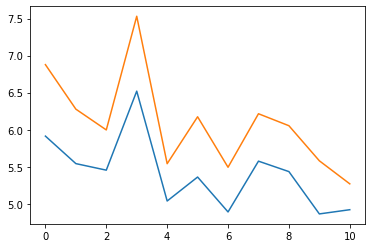

nnodes: 1, seq_range 100 epoch: 11
loss: 5.534, val_loss 6.098
nnodes: 10, seq_range 200 epoch: 12
loss: 4.718, val_loss 5.357
nnodes: 2, seq_range 150 epoch: 13
loss: 4.844, val_loss 5.513
nnodes: 5, seq_range 100 epoch: 14
loss: 5.252, val_loss 5.871
nnodes: 1, seq_range 200 epoch: 15
loss: 5.087, val_loss 5.800
nnodes: 10, seq_range 150 epoch: 16
loss: 4.948, val_loss 5.437
nnodes: 2, seq_range 100 epoch: 17
loss: 5.077, val_loss 5.790
nnodes: 5, seq_range 200 epoch: 18
loss: 4.730, val_loss 5.240
nnodes: 1, seq_range 150 epoch: 19
loss: 4.801, val_loss 5.263
nnodes: 10, seq_range 100 epoch: 20
loss: 4.565, val_loss 5.184


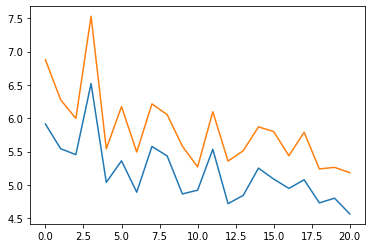

nnodes: 2, seq_range 200 epoch: 21
loss: 4.498, val_loss 5.000
nnodes: 5, seq_range 150 epoch: 22
loss: 4.314, val_loss 4.811
nnodes: 1, seq_range 100 epoch: 23
loss: 5.145, val_loss 5.734
nnodes: 10, seq_range 200 epoch: 24
loss: 4.494, val_loss 4.852
nnodes: 2, seq_range 150 epoch: 25
loss: 4.300, val_loss 4.779
nnodes: 5, seq_range 100 epoch: 26
loss: 4.349, val_loss 5.037
nnodes: 1, seq_range 200 epoch: 27
loss: 4.541, val_loss 5.182
nnodes: 10, seq_range 150 epoch: 28
loss: 4.224, val_loss 4.707
nnodes: 2, seq_range 100 epoch: 29
loss: 4.130, val_loss 4.887
nnodes: 5, seq_range 200 epoch: 30
loss: 3.803, val_loss 4.208


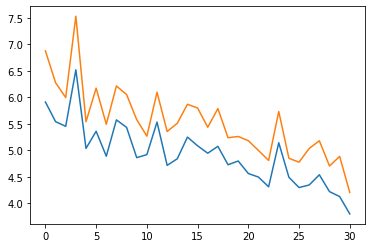

nnodes: 1, seq_range 150 epoch: 31
loss: 4.323, val_loss 4.772
nnodes: 10, seq_range 100 epoch: 32
loss: 4.099, val_loss 4.848
nnodes: 2, seq_range 200 epoch: 33
loss: 4.301, val_loss 4.841
nnodes: 5, seq_range 150 epoch: 34
loss: 3.906, val_loss 4.271
nnodes: 1, seq_range 100 epoch: 35
loss: 4.278, val_loss 4.852
nnodes: 10, seq_range 200 epoch: 36


In [ ]:
n_epochs = 300
nbatch = 300

val_pct = 0.1
fixed_spacing_indices = False;
nnodes_schedule =     [10,2,5,1]#2,2,3,3]#,1,2,2,1,1,3,3]
nseq_range_schedule = [200,150,100];
min_spacing_schedule =[10];
iterations_schedule = [5]
#nnodes_schedule = [1,2,4,4,5,10,5]
#nseq_range_schedule = [2,5,15,15,20,50,30]
#min_spacing_schedule = [1,1,1,1,1,1]
#iterations_schedule =  [3,2,3,3,4]

#nnodes_schedule = [1,2,5]
#nseq_range_schedule = [20]
#min_spacing_schedule = [1,1,1]
#iterations_schedule = [3,3,3]

for i in range(n_epochs):
    np.random.seed(42); 
    epoch = i
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = eval_graphnets(graph_curr.copy(), iterations)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights = [*gn.weights(), *graph_indep.weights()];
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        

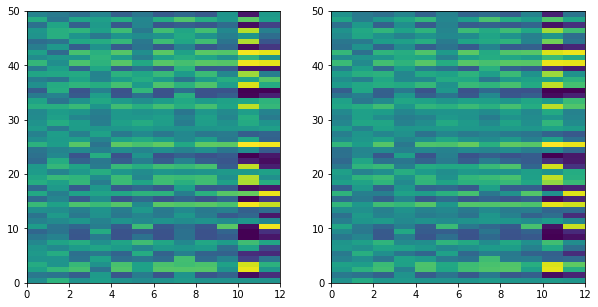

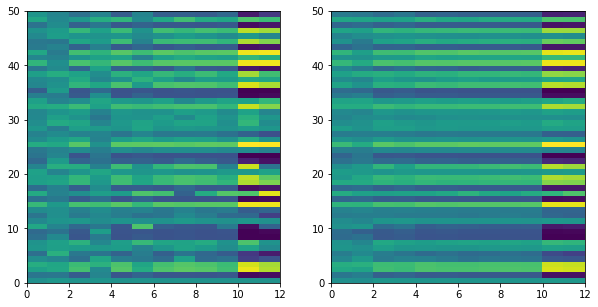

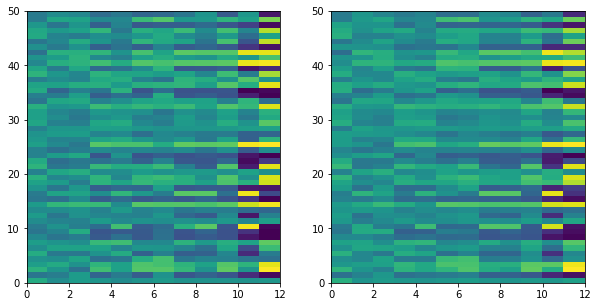

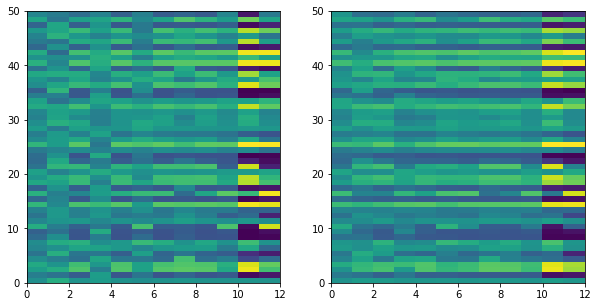

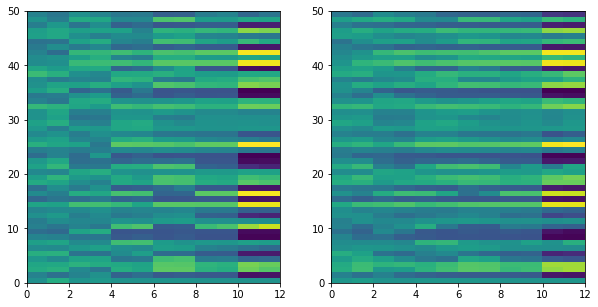

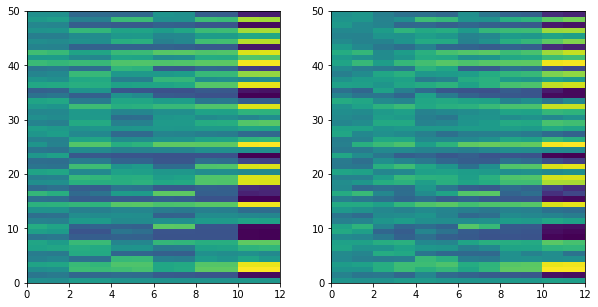

In [165]:
def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp]
    for iterations in range(iterations):
        graph_out_tmp = gn.graph_eval(graph_out_tmp) + graph_out_tmp
        lat_states.append(graph_out_tmp)
    return lat_states

curr_data = get_multi_batch(2, source_ds=True,nnodes=5,
                            min_spacing = 20,
                            nseq_range = 100,
                            fixed_spacing_indices=True);
c = curr_data[0][0]


for c in curr_data:
    c = c[0]
    c = graphnet_latent_states(c.copy(), iterations =5)
    pplot.figure(figsize = (10,5)) 
    pplot.subplot(1,2,1)
    pplot.pcolor(np.vstack([c_.nodes[-1].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.subplot(1,2,2)
    pplot.pcolor(np.vstack([c_.nodes[0].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.show()
    

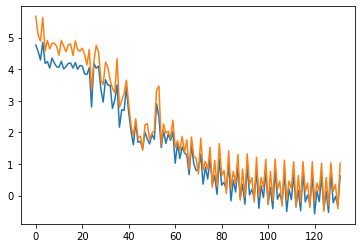

In [166]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


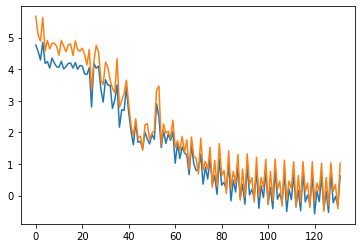

In [167]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


10


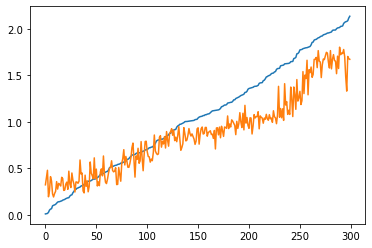

In [168]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)
prob_out = eval_graphnets(graph_curr.copy(), iterations)

ids_sort = np.argsort(y_curr);
pplot.plot(y_curr[ids_sort])
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [169]:
inds_exp_target

[5, 7, 16, 2]

In [170]:
# Inspect the learned embeddings for different experiments. See if some of them cluster.
def get_exp_dat(exp_num, keep_from_end):
    ids = np.argmax(eid_oh,1) == exp_num
    
    return X[ids][-keep_from_end:,:,:],yrem_norm[ids][-keep_from_end:]
#embs = graph_indep.node_function(get_exp_dat(1))
#graph_indep.node_function.summary()

keep_from_end = 100;
all_embs = []
exp_inds_plot = []
yfrom_ends = []
for ee in [*inds_exp_source, *inds_exp_target]:
    g, gg = get_exp_dat(ee, keep_from_end)
    
    e = graph_indep.node_function([np.zeros([g.shape[0],1]).astype("float32") ,g])
    all_embs.append(e)
    exp_inds_plot.append([ee]*keep_from_end)
    yfrom_ends.append(gg)
    
    
exp_inds_plot = np.hstack(exp_inds_plot)
yfrom_ends = np.hstack(yfrom_ends)
#graph_indep.node_function.inputs

#graph_indep.node_function()


In [171]:
istarget = np.zeros_like(exp_inds_plot)
istarget[[e_ for e_,e in enumerate(exp_inds_plot) if e in inds_exp_target]] = 1


In [172]:
all_embs_ = np.vstack([a.numpy() for a in all_embs])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=4);
tsne = TSNE(n_components=2);
tsne= tsne.fit_transform(all_embs_)
#pplot.scatter(epca[:,0],epca[:,1])


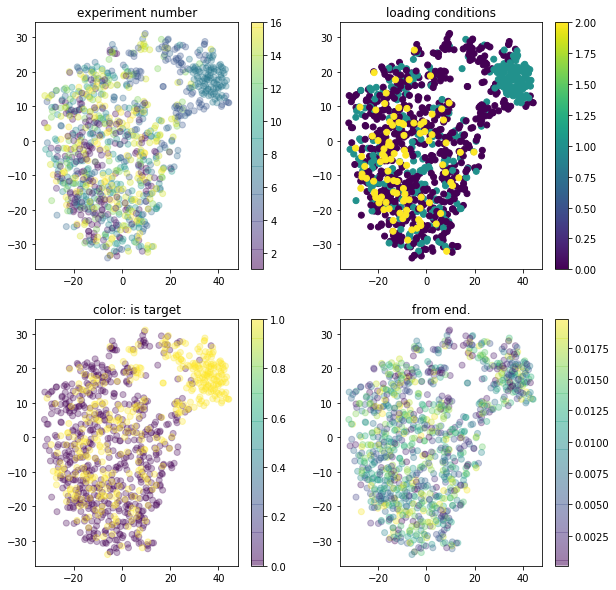

In [173]:
pplot.figure(figsize = (10,10))
pplot.subplot(2,2,1)
pplot.scatter(tsne[:,0], tsne[:,1],c = exp_inds_plot, alpha = 0.3)
pplot.title("experiment number")
pplot.colorbar()
pplot.subplot(2,2,2)
pplot.scatter(tsne[:,0], tsne[:,1],c = [exp_to_cond_dict[k] for k in exp_inds_plot])
pplot.title("loading conditions")
pplot.colorbar()
pplot.subplot(2,2,3)
pplot.scatter(tsne[:,0], tsne[:,1], c = istarget, alpha = 0.3)
pplot.title("color: is target")
pplot.colorbar()
pplot.subplot(2,2,4)
pplot.scatter(tsne[:,0], tsne[:,1], c = yfrom_ends, alpha = 0.3)
pplot.title("from end.")
pplot.colorbar()
pplot.show()


In [174]:
[exp_to_cond_dict[ii] for ii in inds_exp_source], inds_exp_source

([0, 0, 0, 1, 1, 0], [1, 6, 8, 9, 13, 15])

In [175]:
#inds_exp_source, inds_exp_target 
targets =[t for t in inds_exp_target if t not in inds_exp_target]
#[(t, exp_to_cond_dict[t]) for t in targets],[(t, exp_to_cond_dict[t]) for t in inds_exp_source]


In [176]:
inds_exp_source

[1, 6, 8, 9, 13, 15]

target


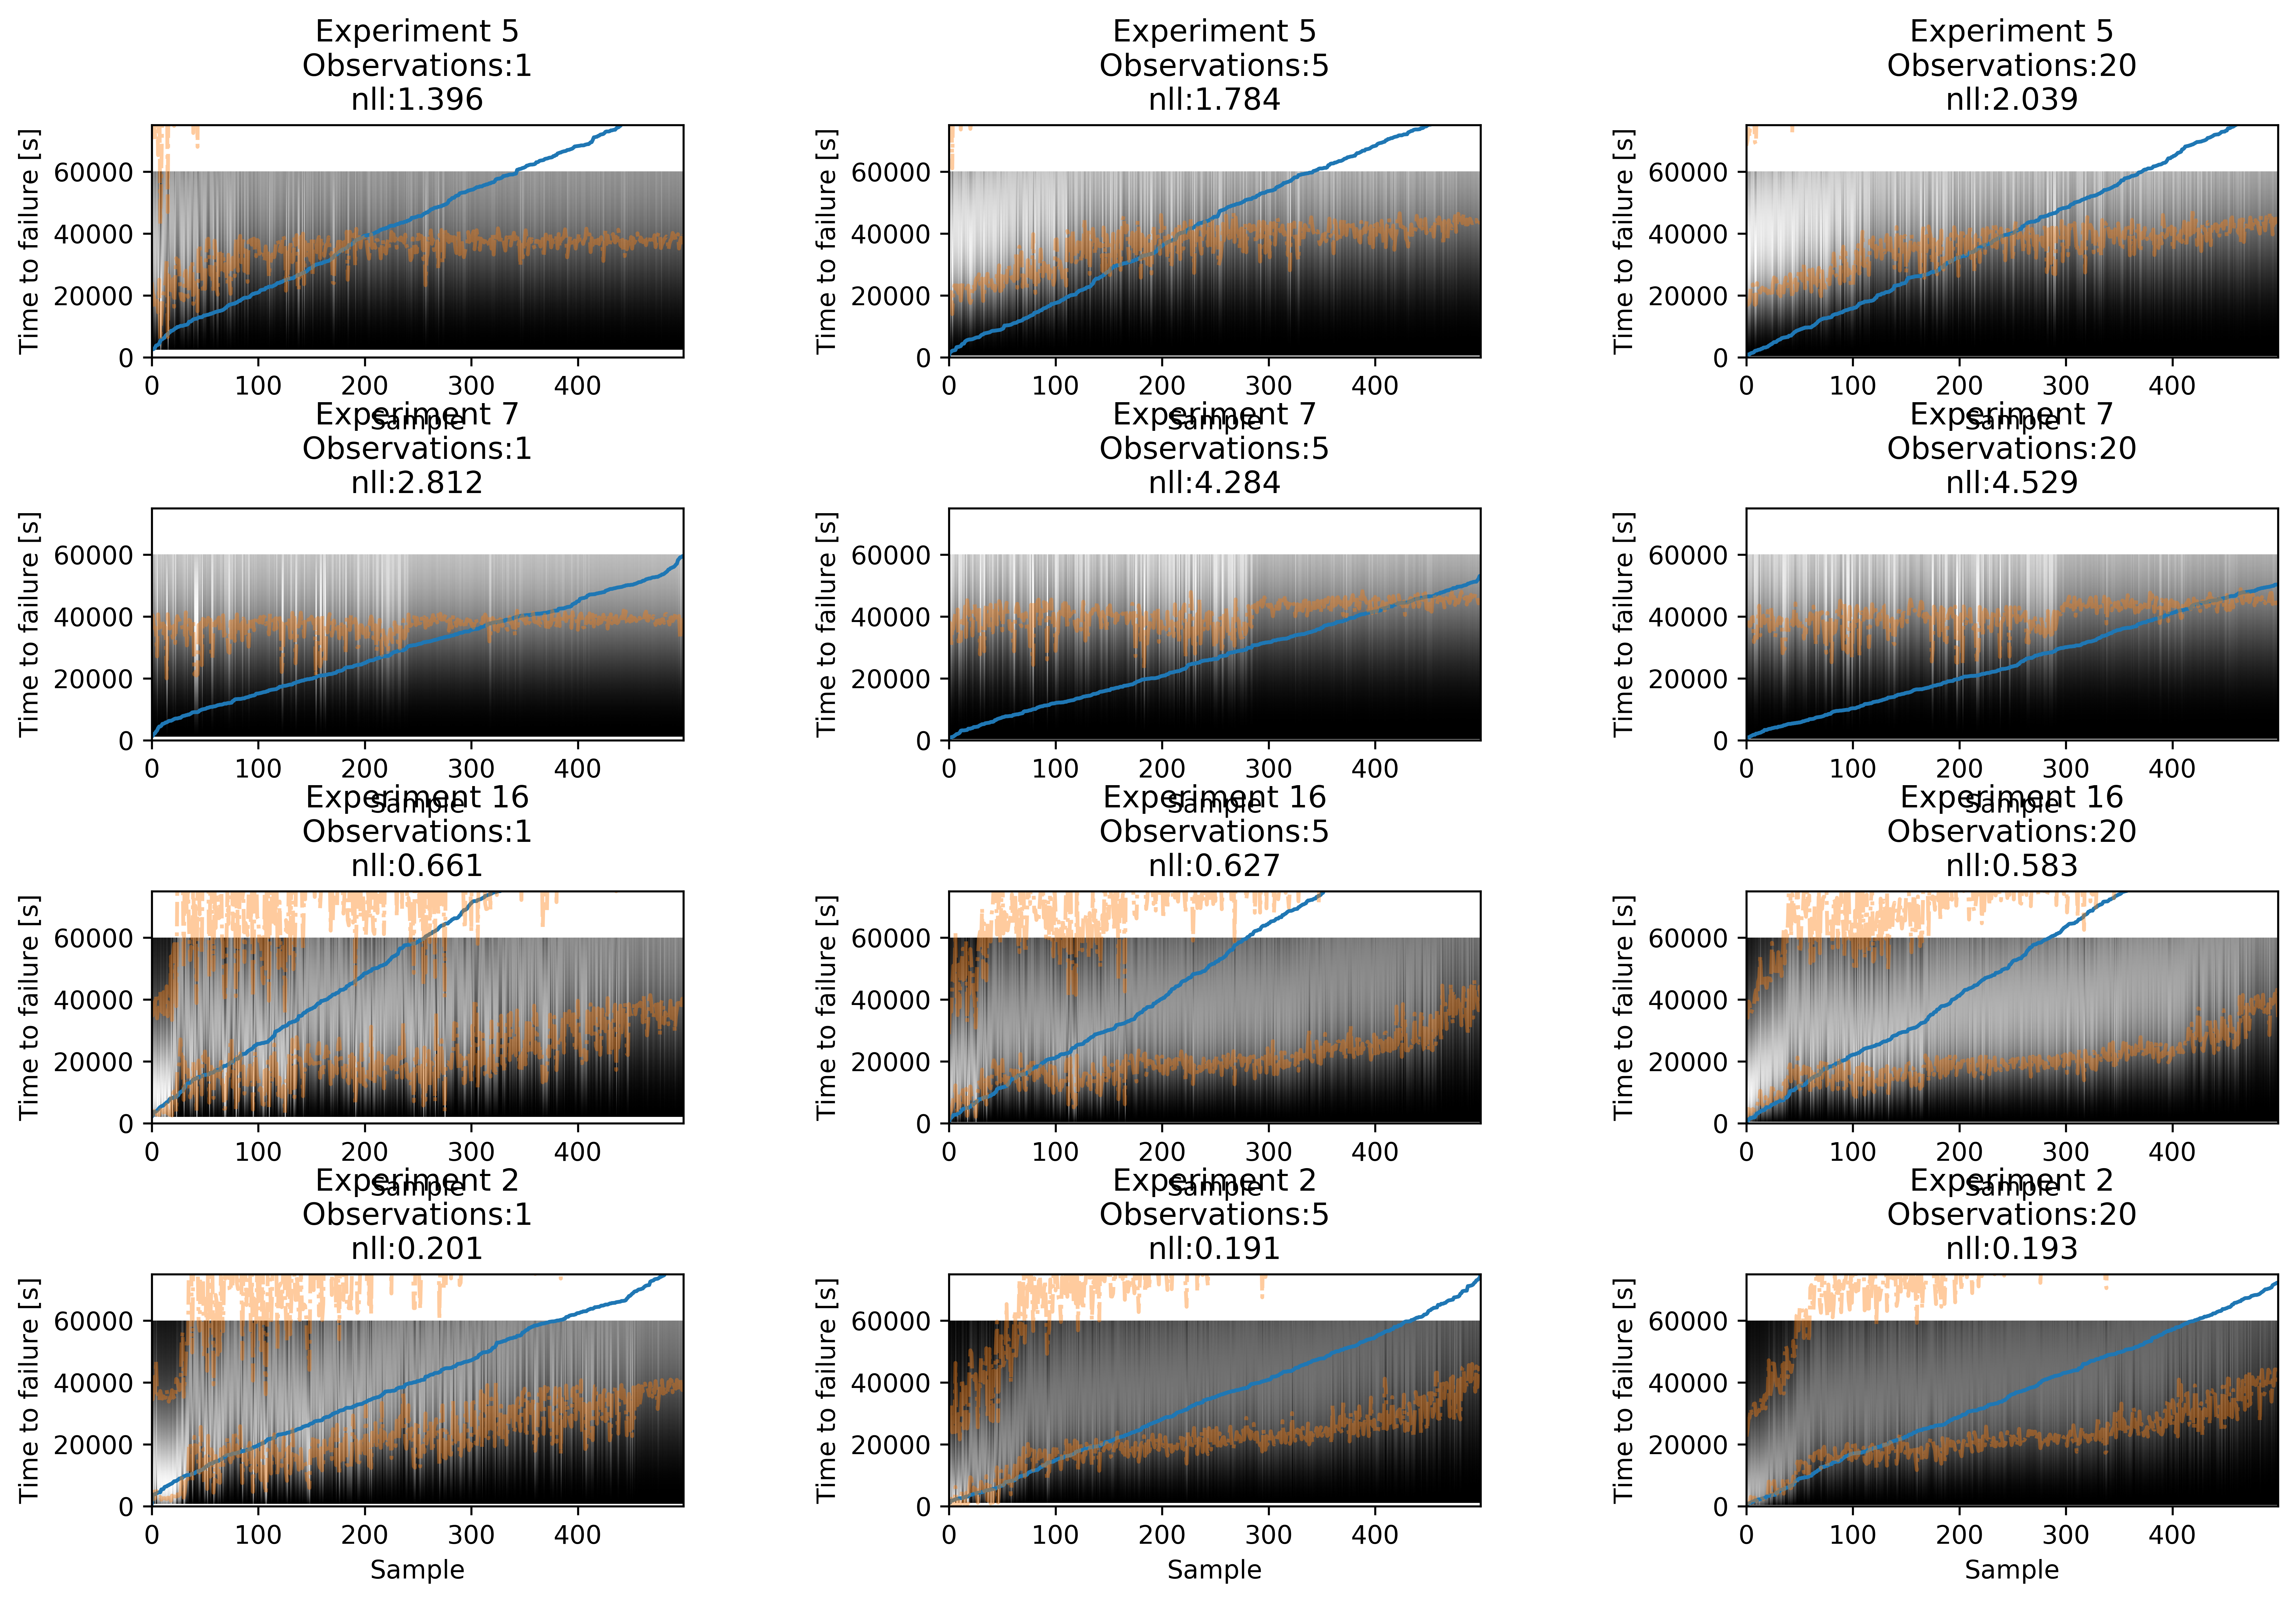

source:


<Figure size 432x288 with 0 Axes>

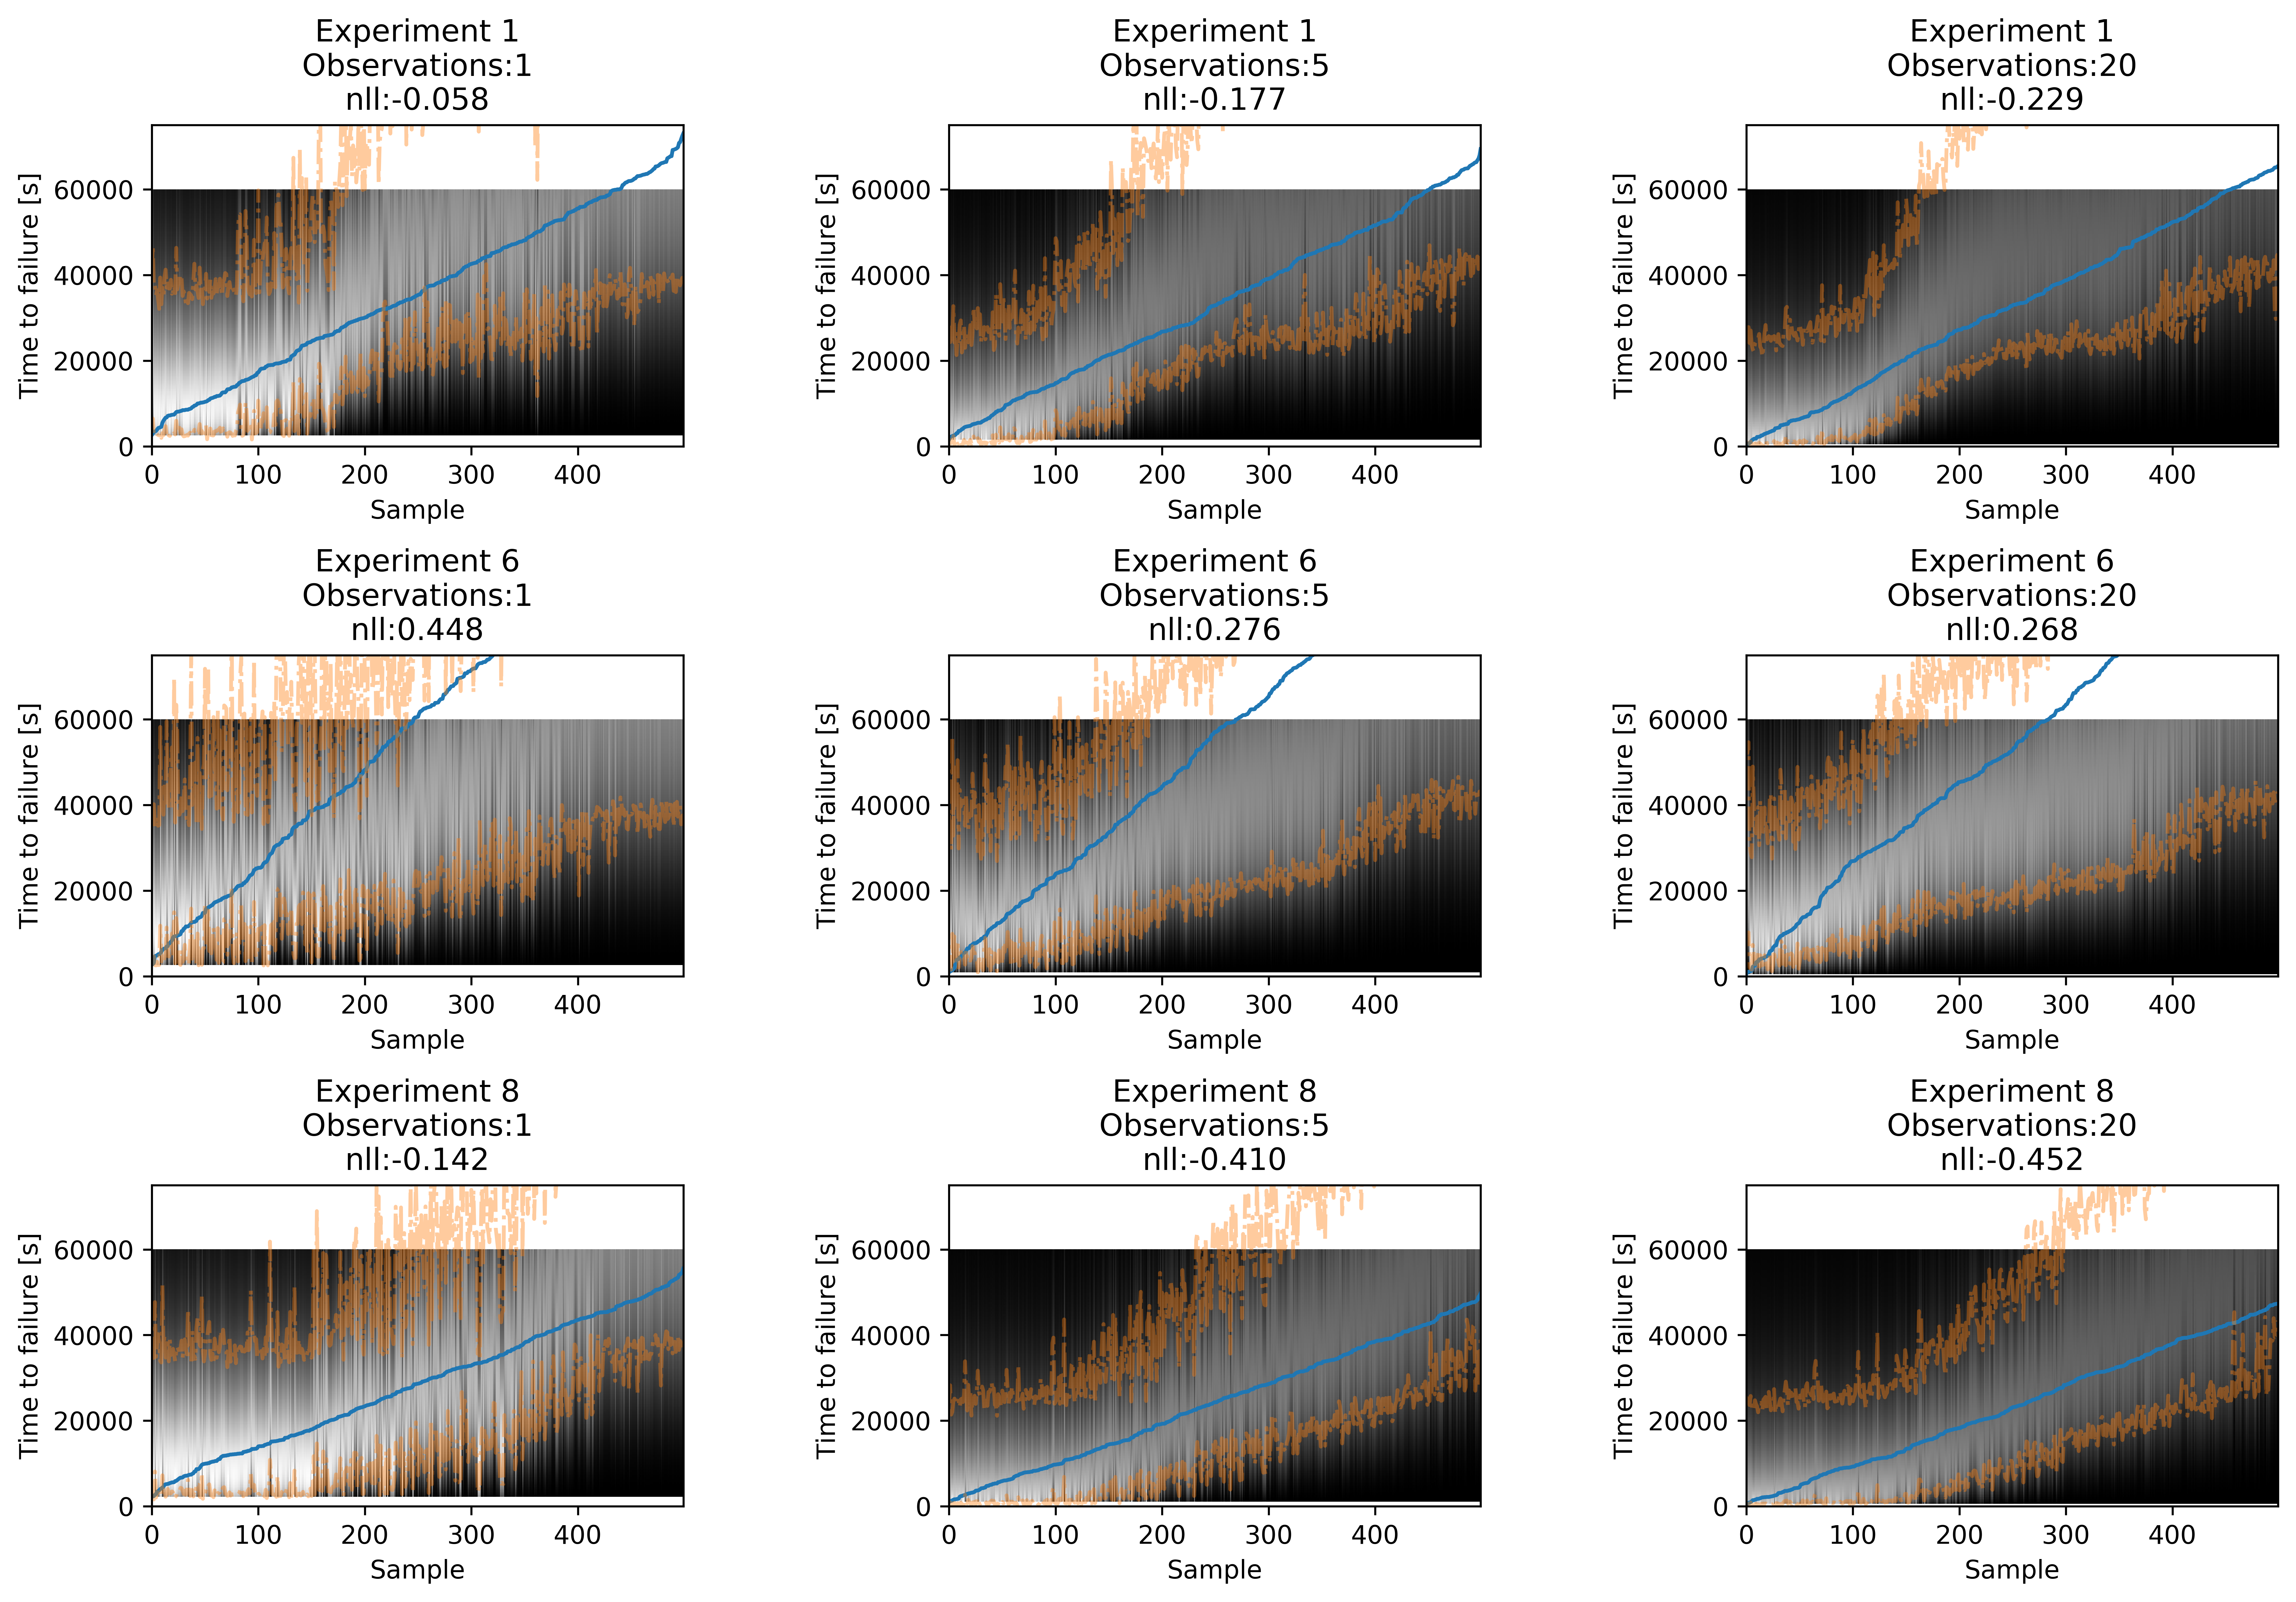

<Figure size 432x288 with 0 Axes>

In [177]:

def plot_experiments(experiments_to_plot):
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,10), dpi = 600)
    nnodes_list = [1,5,20]#,3,5]
    nseq_len = [200,200,200]
    minspacing= [10,10,10]
    gnsteps  = [ 5,5,5]
    
    kk = 0;
    for ee in experiments_to_plot:
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
            #ee = training[0]
            graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh,
                                             yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, 
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            probs = eval_graphnets(graphs,gnsteps_)
            #eval_graphnets()
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
            time_grid = np.linspace(np.min(y_times), 60000./normalization_factor_time, 150)
            #time_grid = np.linspace(np.min(y_times),3.5, 150);

            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray")
            pplot.plot(y_times_sorted  *normalization_factor_time)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(q90*normalization_factor_time,'C1-.', alpha = 0.4)
            pplot.ylim(0,75000)
            pplot.xlabel("Sample")
            pplot.ylabel("Time to failure [s]")

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

            title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
            pplot.title(title)
            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
    pplot.show()
    
#unseen =  inds_exp_source[3:6]#[4:7]#inds_exp_source[0:3] #inds_exp_target[0:3]
unseen = targets[0:3]#[0:1]#inds_exp_source[0:3] #inds_exp_target[0:3]
print("target")
plot_experiments(inds_exp_target)
pplot.savefig("graphnet_result_testset.png")
print("source:")
plot_experiments(inds_exp_source[0:3])
pplot.savefig("graphnet_result_trainset.png")

In [178]:
print("training set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_source]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
print("\ntesting set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_target]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
#plot_experiments([10])


training set:
01 0 1_7 1502
06 0 1_5 2302
08 0 1_4 1139
09 1 2_5 2002
13 1 2_1 911
15 0 1_1 2803

testing set:
05 0 1_3 1802
07 1 2_3 1202
16 0 1_6 2302
02 2 3_2 1637


In [58]:
n = Node()
Graph(n,e)

TypeError: __init__() missing 1 required positional argument: 'node_attr_tensor'

In [59]:
#plot_experiments(targets[0:2])
plot_experiments([5,2,16])


ValueError: num must be 1 <= num <= 0, not 1

<Figure size 9000x6000 with 0 Axes>

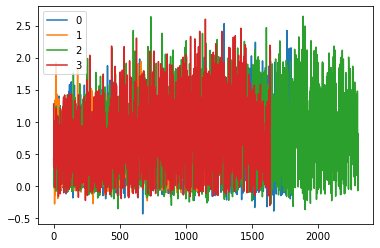

In [225]:
for m in range(len(inds_exp_target)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_target[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
    
pplot.legend()

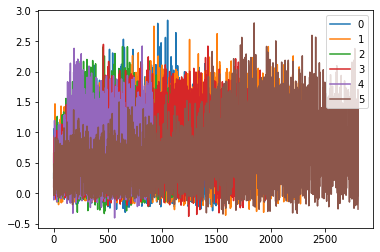

In [226]:
for m in range(len(inds_exp_source)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_source[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
pplot.legend()

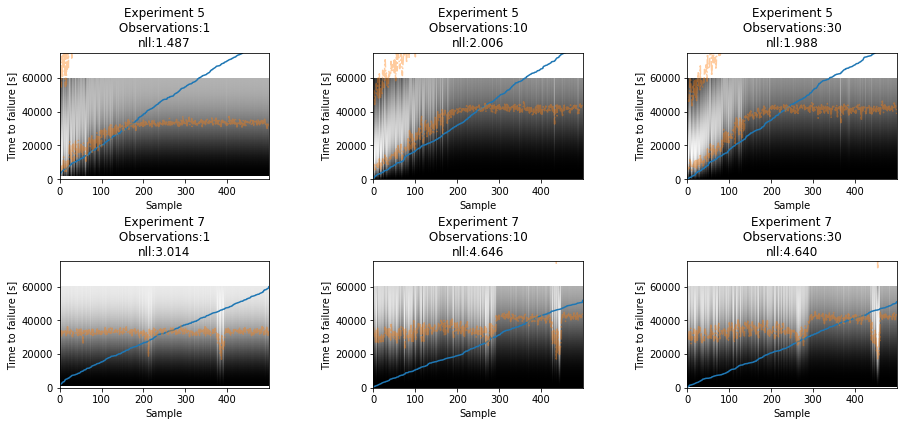

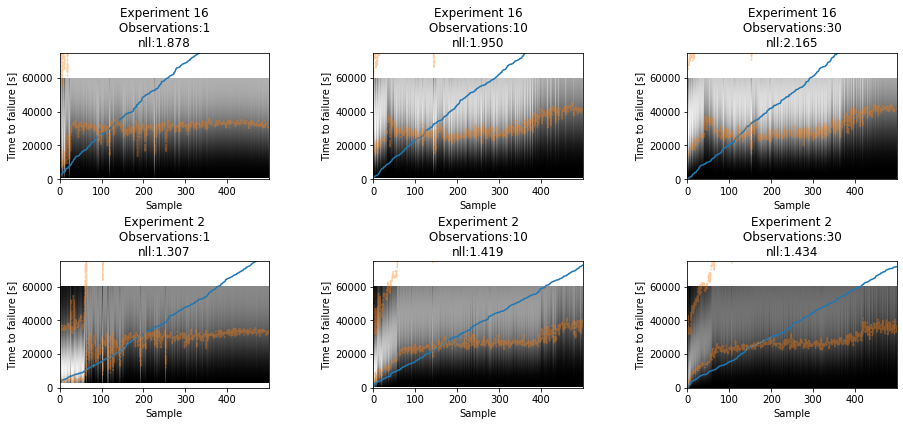

In [127]:
plot_experiments(inds_exp_target[:2])
plot_experiments(inds_exp_target[2:])


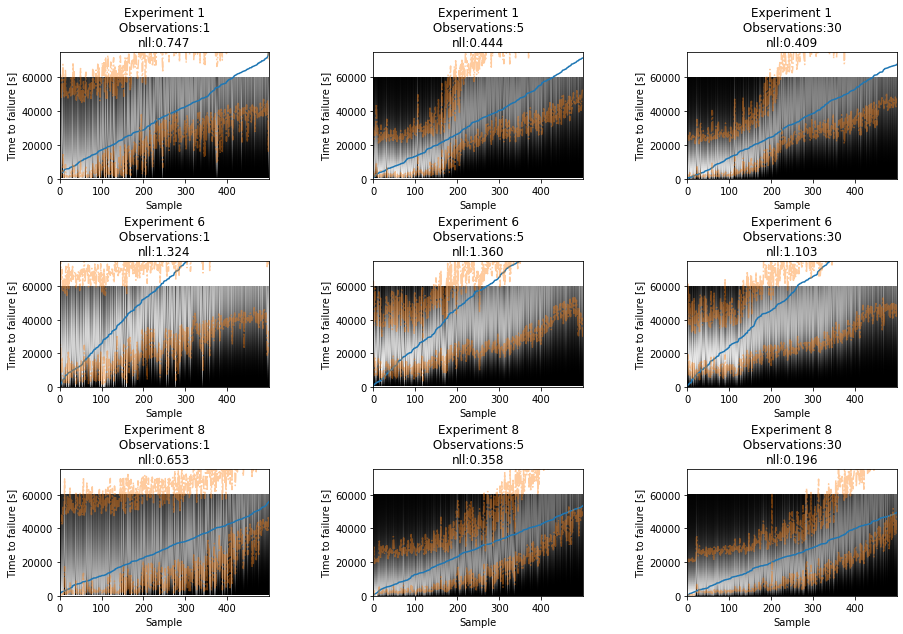

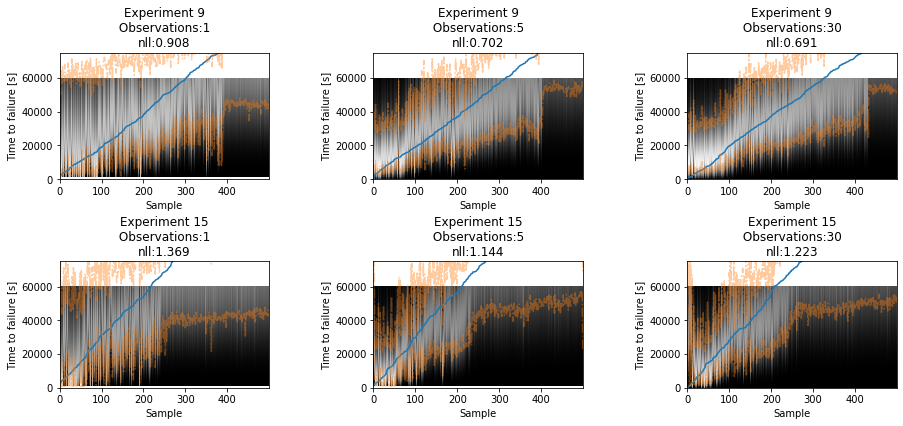

In [168]:

plot_experiments(inds_exp_source[0:3])
plot_experiments(inds_exp_source[3:6])

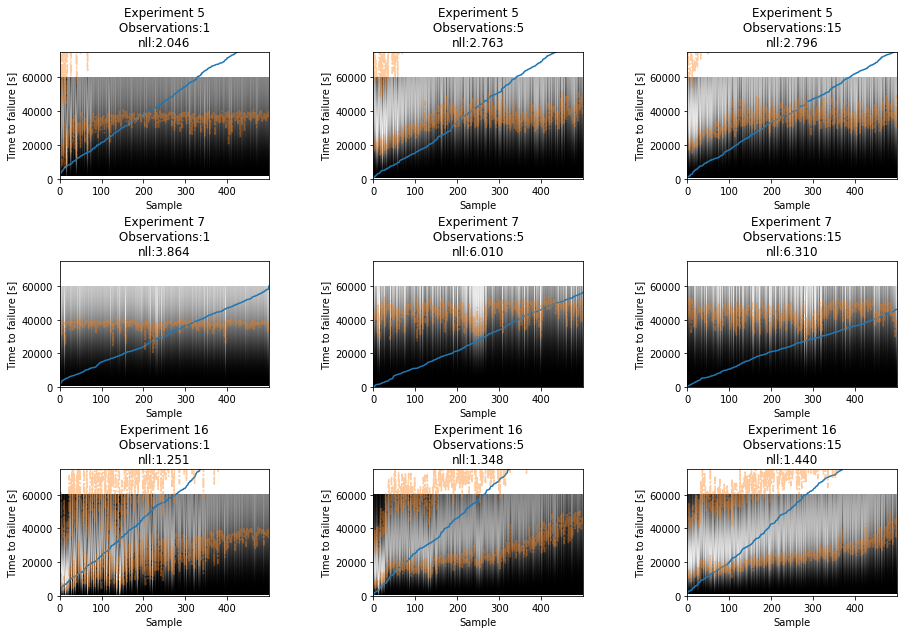

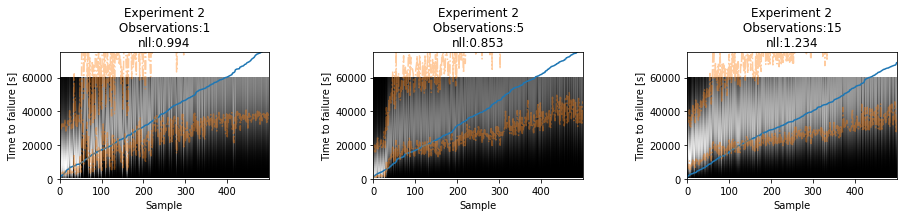

In [227]:

plot_experiments(inds_exp_target[0:3])
plot_experiments(inds_exp_target[3:])


In [119]:

inds_exp_target

[5, 7, 16, 2]

In [715]:

inds_exp_target

[5, 7, 16, 2]

In [717]:
gn